In [1]:
from abc import ABC, abstractmethod
import glob
import numpy as np
import pandas as pd
from scipy import stats
import torch
from torch import nn
from torch import utils
from torch import optim

from sklearn.metrics import r2_score
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_built()
if use_cuda:
    device = torch.device('cuda')
elif use_mps:
    device = torch.device('mps')
else:
    device = torch.device('cpu')
cpu = torch.device('cpu')

In [4]:
default_batch_size = 256
loader_args = {'batch_size' : default_batch_size, 'shuffle' : True, 'num_workers' : 0}
if use_cuda:
    loader_args.update({'pin_memory' : True})

In [5]:
class SLReporter(ABC):
    @abstractmethod
    def train_gather(self, epoch, batch_idx, batch_size, dataset_size, loss):
        pass
    @abstractmethod
    def eval_gather(self, train_epoch, loss, accuracy):
        pass
    @abstractmethod
    def eval_pred_gather(self, train_epoch, predictions, targets):
        pass
    @abstractmethod
    def train_reset(self):
        pass
    @abstractmethod
    def eval_reset(self):
        pass

class SLEpochLossReporter(SLReporter):
    def __init__(self, batch_size, frequency, report_frequency = 0, eval_report_frequency = 0):
        self.batch_size = batch_size
        self.frequency = frequency
        self.report_frequency = report_frequency
        self.eval_report_frequency = eval_report_frequency
        self.losses = []
        self.eval_losses = []
        self.eval_predictions_targets = []
    def train_gather(self, epoch, batch_idx, dataset_size, loss):
        if epoch % self.frequency == 0 and (batch_idx + 1) * self.batch_size >= dataset_size:
            self.losses.append((epoch, loss))
        if self.report_frequency > 0 and epoch % self.report_frequency == 0 and (batch_idx + 1) * self.batch_size >= dataset_size:
            print("Epoch {}, {}/{}: {}".format(epoch, batch_idx * self.batch_size, dataset_size, loss))
    def eval_gather(self, train_epoch, loss, accuracy):
        self.eval_losses.append((train_epoch, loss, accuracy))
        if self.eval_report_frequency > 0 and train_epoch % self.eval_report_frequency == 0:
            print("Epoch {}: loss {} accuracy {}".format(train_epoch, loss, accuracy))
    def eval_pred_gather(self, train_epoch, predictions, targets):
        self.eval_predictions_targets.append((train_epoch, predictions, targets))
    def train_reset(self):
        self.losses = []
    def eval_reset(self):
        self.eval_losses = []
        self.eval_predictions_targets = []

class SLBatchLossReporter(SLReporter):
    def __init__(self, batch_size, frequency, report_frequency = 0, eval_report_frequency = 0):
        self.batch_size = batch_size
        self.frequency = frequency
        self.report_frequency = report_frequency
        self.eval_report_frequency = eval_report_frequency
        self.losses = []
        self.eval_losses = []
        self.eval_predictions_targets = []
    def train_gather(self, epoch, batch_idx, dataset_size, loss):
        if epoch % self.frequency == 0 and (batch_idx + 1) * self.batch_size >= dataset_size:
            self.losses.append((epoch, loss))
        if self.report_frequency > 0 and epoch % self.report_frequency == 0:
            print("Epoch {}, {}/{}: {}".format(epoch, batch_idx * self.batch_size, dataset_size, loss))
    def eval_gather(self, train_epoch, loss, accuracy):
        self.eval_losses.append((train_epoch, loss, accuracy))
        if self.eval_report_frequency > 0 and train_epoch % self.eval_report_frequency == 0:
            print("Epoch {}: loss {} accuracy {}".format(train_epoch, loss, accuracy))
    def eval_pred_gather(self, train_epoch, predictions, targets):
        self.eval_predictions_targets.append((train_epoch, predictions, targets))
    def train_reset(self):
        self.losses = []
    def eval_reset(self):
        self.eval_losses = []
        self.eval_predictions_targets = []

In [6]:
data_dir = '../data/'

In [7]:
files = glob.glob(data_dir + 'etl_s2_v2*.parquet')
files

['../data/etl_s2_v2_1680419520_1680590400.parquet',
 '../data/etl_s2_v2_1680112320_1680265920.parquet',
 '../data/etl_s2_v2_1679805120_1679958720.parquet',
 '../data/etl_s2_v2_1679958720_1680112320.parquet',
 '../data/etl_s2_v2_1680590400_1680744000.parquet',
 '../data/etl_s2_v2_1679178240_1679331840.parquet',
 '../data/etl_s2_v2_1680265920_1680419520.parquet',
 '../data/etl_s2_v2_1679485440_1679651520.parquet',
 '../data/etl_s2_v2_1679651520_1679805120.parquet',
 '../data/etl_s2_v2_1679331840_1679485440.parquet']

In [8]:
ticker = 'ETH-USD'

In [9]:
data = pd.read_parquet(files[0])
columns = data.columns

In [10]:
ticker_columns = []
for col in columns:
    if col.startswith(ticker):
        ticker_columns.append(col)

In [11]:
ticker_columns += ['book_mean_return_27', 'sequence_interval_s']

In [12]:
len(ticker_columns)

710

In [13]:
data = pd.DataFrame(columns=ticker_columns)
for file in files:
    df = pd.read_parquet(file, columns=ticker_columns)
    data = pd.concat([data, df])

In [14]:
data.sort_index(inplace=True)

In [15]:
data.shape

(1530331, 710)

In [16]:
target_columns = [
    (f'{ticker}:book_volatility_9',   9,   f'{ticker}:book_volatility_9_target'),
    (f'{ticker}:book_volatility_27',  27,  f'{ticker}:book_volatility_27_target'),
    (f'{ticker}:book_volatility_81',  81,  f'{ticker}:book_volatility_81_target'),
    (f'{ticker}:book_volatility_162', 162, f'{ticker}:book_volatility_162_target'),
    (f'{ticker}:book_volatility_324', 324, f'{ticker}:book_volatility_324_target'),
    (f'{ticker}:book_volatility_648', 648, f'{ticker}:book_volatility_648_target'),
    (f'{ticker}:book_volatility_960', 960, f'{ticker}:book_volatility_960_target'),
]

In [17]:
target_column_names = [colname for (_, _, colname) in target_columns]

In [18]:
for (colname, offset, tcolname) in target_columns:
    data[tcolname] = data[colname]
    data[tcolname] = data[tcolname].shift(-1 * offset)

In [19]:
data = data.drop([data.index[k] for k in range(-1, -961, -1)])

In [20]:
data.shape

(1529371, 717)

In [21]:
data.isna().sum().sum()

7082640

In [22]:
data.fillna(method='ffill', inplace=True)

In [23]:
for col in data.columns:
    max_val = np.nanmax(data[col][data[col] != np.inf])
    min_val = np.nanmin(data[col][data[col] != -np.inf])
    data[col].replace([np.inf, -np.inf], [max_val, min_val], inplace=True)

In [24]:
data.isna().sum().sum()

0

In [25]:
data.fillna(0., inplace=True)

In [26]:
input_columns = [col for col in data.columns if col not in target_column_names]

In [27]:
X = np.float32(data[input_columns].to_numpy())

In [28]:
Y = np.float32(data[target_column_names].to_numpy())

In [29]:
def ts_train_test_split(X, Y, pct):
    n = X.shape[0]
    train_size = int(n * (1 - pct))
    X_train = X[:train_size]
    Y_train = Y[:train_size]
    X_test = X[train_size:]
    Y_test = Y[train_size:]
    return (X_train, Y_train, X_test, Y_test)

In [30]:
X_train, Y_train, X_test, Y_test = ts_train_test_split(X, Y, 0.2)

In [31]:
# normalize X otherwise neural network becomes degenerative

In [32]:
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)

In [33]:
X_train_std[X_train_std == 0.] = 1.

In [34]:
X_train_norm = (X_train - X_train_mean) / X_train_std
X_test_norm = (X_test - X_train_mean) / X_train_std

In [35]:
Y_train_mean = Y_train.mean(axis=0)
Y_train_std = Y_train.std(axis=0)

In [36]:
Y_train_norm = (Y_train - Y_train_mean) / Y_train_std
Y_test_norm = (Y_test - Y_train_mean) / Y_train_std

In [37]:
class Dataset(utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return (x, y)

    def __len__(self):
        return self.X.shape[0]

In [38]:
# NN Model

In [39]:
class NN_V1(nn.Module):
    def __init__(self, isz, osz, hsz):
        super(NN_V1, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(isz, hsz),
            nn.SiLU(inplace=True),
            nn.Linear(hsz, osz),
        )

    def forward(self, x):
        y = self.layers(x)
        return y

In [40]:
def regression_train(model, device, loader, optimizer, loss, epoch, reporter):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output = model(data)
        l = loss(output, target)
        l.backward()
        optimizer.step()
        reporter.train_gather(epoch, batch_idx, len(loader.dataset), l.item())

In [41]:
def regression_validate(model, device, loader, loss, train_epoch, reporter):
    model.eval()
    total_loss = 0.
    with torch.no_grad():
        for (data, target) in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += loss(output, target).item()
            reporter.eval_pred_gather(train_epoch, output, target)
    total_loss /= len(loader.dataset)
    #NOTE: regression does not have accuracy
    reporter.eval_gather(train_epoch, total_loss, total_loss)

In [42]:
def regression_train_validate(model, device, train_loader, eval_loader, optimizer, scheduler, loss, total_epoch, patience, patience_decay, reporter):
    validation_loss = 1.
    patience_count = patience
    patience = int(patience * patience_decay)
    reset_patience = False
    for epoch in range(total_epoch):
        regression_train(model, device, train_loader, optimizer, loss, epoch, reporter)
        regression_validate(model, device, eval_loader, loss, epoch, reporter)
        new_validation_loss = reporter.eval_losses[-1][1]
        scheduler.step(new_validation_loss)
        if new_validation_loss < validation_loss:
            print("Validation Loss: {}".format(new_validation_loss))
            validation_loss = new_validation_loss
            patience_count = patience
            if reset_patience:
                patience = int(patience * patience_decay)
                reset_patience = False
        else:
            print("Validation Loss: {}".format(new_validation_loss))
            validation_loss = new_validation_loss
            patience_count -= 1
            reset_patience = True
            if patience_count <= 0:
                print("Improvement stopped at epoch {}, validation loss {}".format(epoch, new_validation_loss))
                break

In [43]:
# training

In [44]:
trainset, evalset = Dataset(X_train_norm, Y_train_norm), Dataset(X_test_norm, Y_test_norm)

In [45]:
train_loader = utils.data.DataLoader(trainset, **loader_args)
eval_loader = utils.data.DataLoader(evalset, **loader_args)

In [46]:
model = NN_V1(len(input_columns), len(target_column_names), 2048)
model = model.to(device)

In [47]:
learning_rate = 0.00001
total_epochs = 30
patience = 14
patience_decay = 0.8
optimizer = optim.Adam(model.parameters(recurse=True), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=patience / 4, threshold=0.000001)
loss = nn.MSELoss()
reporter = SLEpochLossReporter(default_batch_size, 1, 1)

In [48]:
regression_train_validate(model, device, train_loader, eval_loader, optimizer, scheduler, loss, total_epochs, patience, patience_decay, reporter)

Epoch 0, 1223424/1223496: 0.21627748012542725
Validation Loss: 0.0019699367625303156
Epoch 1, 1223424/1223496: 0.45184385776519775
Validation Loss: 0.002033294437805584
Epoch 2, 1223424/1223496: 0.35885217785835266
Validation Loss: 0.0021055521287867427
Epoch 3, 1223424/1223496: 0.3900313079357147
Validation Loss: 0.002171987459130515
Epoch 4, 1223424/1223496: 0.4871688485145569
Validation Loss: 0.0022129407882885295
Epoch 5, 1223424/1223496: 0.30257266759872437
Validation Loss: 0.0022404353126585118
Epoch 6, 1223424/1223496: 0.21448682248592377
Validation Loss: 0.0022572724551242567
Epoch 7, 1223424/1223496: 0.20828697085380554
Validation Loss: 0.0022680044179065988
Epoch 8, 1223424/1223496: 0.3153412938117981
Validation Loss: 0.002275933644505584
Epoch 9, 1223424/1223496: 0.6706161499023438
Validation Loss: 0.0022721424135910425
Epoch 10, 1223424/1223496: 0.3427060842514038
Validation Loss: 0.0022724407151810335
Epoch 11, 1223424/1223496: 0.7610459327697754
Validation Loss: 0.0022719

In [49]:
X_valid = torch.tensor(X_test_norm, dtype=torch.float32).to(device)
Y_predict_norm = model(X_valid).to(cpu).detach().numpy()
Y_predict = (Y_predict_norm * Y_train_std) + Y_train_mean

In [50]:
r, p = pearsonr(Y_test[:,0], Y_predict[:,0])
r

0.6855795682796377

In [51]:
r, p = pearsonr(Y_test[:,1], Y_predict[:,1])
r

0.7298175197565319

In [52]:
r, p = pearsonr(Y_test[:,3], Y_predict[:,3])
r

0.6713278804084245

In [53]:
r, p = pearsonr(Y_test[:,6], Y_predict[:,6])
r

0.4516059876387696

In [54]:
r2_score(Y_test, Y_predict)

0.3615026738965655

In [55]:
# plotting it out

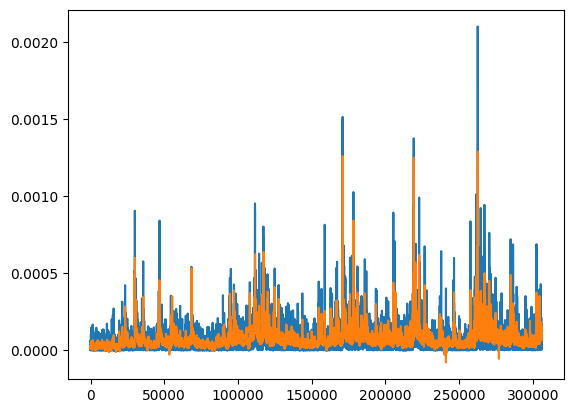

In [56]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,0])
ax.plot(Y_predict[:,0])

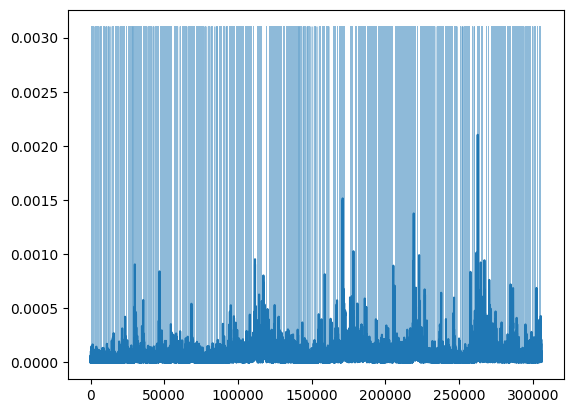

In [57]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,0])
ax.fill_between(range(Y_test.shape[0]), min(Y_test[:,0]), max(Y_test[:,0]) + 0.001, where=np.abs(Y_test[:,0] - Y_predict[:,0]) < 0.00005, alpha=0.5)

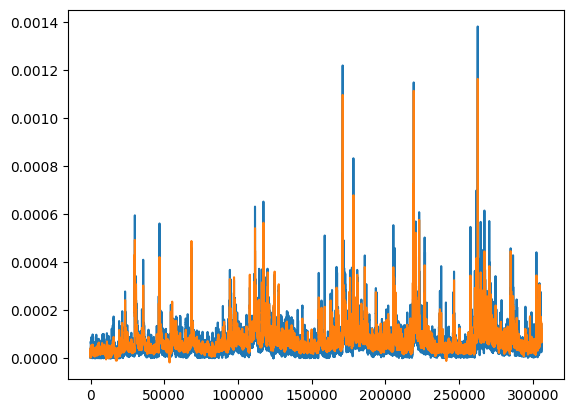

In [58]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,1])
ax.plot(Y_predict[:,1])

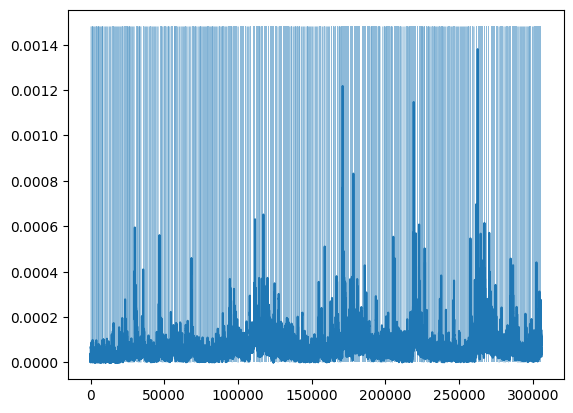

In [59]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,1])
ax.fill_between(range(Y_test.shape[0]), min(Y_test[:,1]), max(Y_test[:,1]) + 0.0001, where=np.abs(Y_test[:,1] - Y_predict[:,1]) < 0.00005, alpha=0.5)

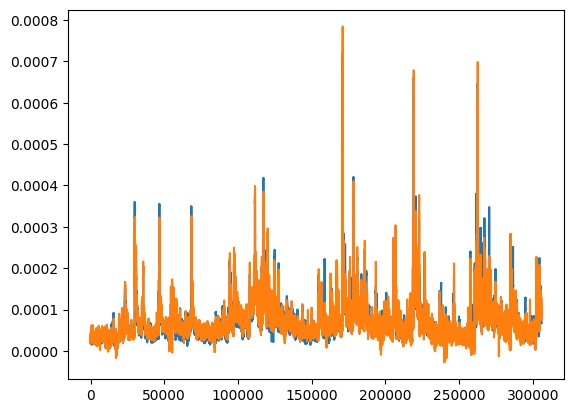

In [60]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,3])
ax.plot(Y_predict[:,3])

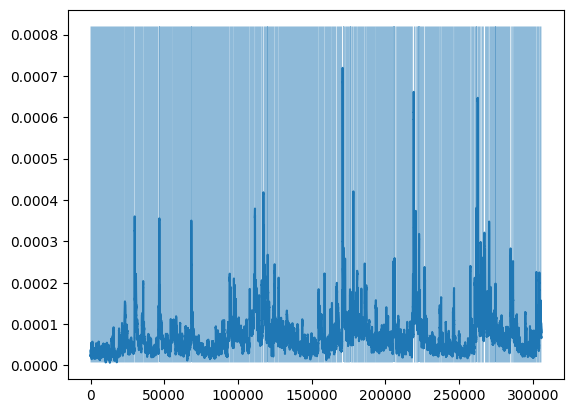

In [61]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,3])
ax.fill_between(range(Y_test.shape[0]), min(Y_test[:,3]), max(Y_test[:,3]) + 0.0001, where=np.abs(Y_test[:,3] - Y_predict[:,3]) < 0.0001, alpha=0.5)

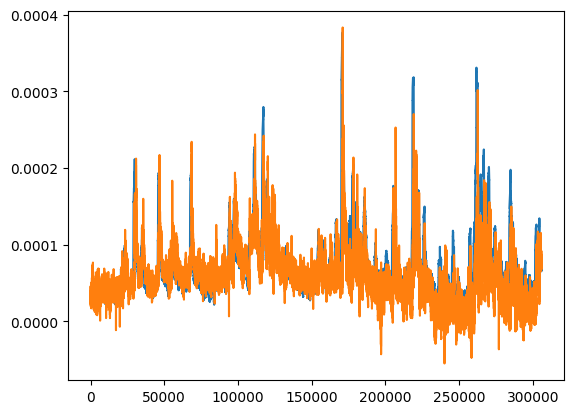

In [62]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,6])
ax.plot(Y_predict[:,6])

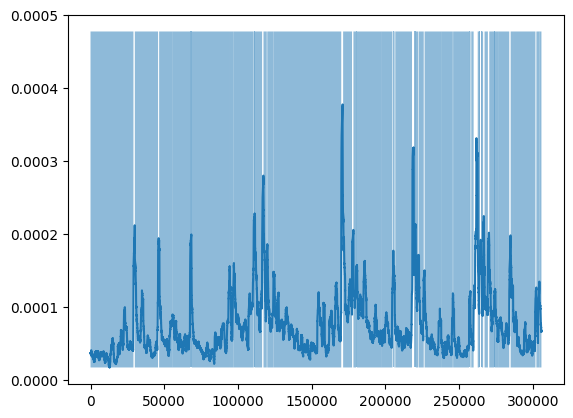

In [63]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,6])
ax.fill_between(range(Y_test.shape[0]), min(Y_test[:,6]), max(Y_test[:,6]) + 0.0001, where=np.abs(Y_test[:,6] - Y_predict[:,6]) < 0.0001, alpha=0.5)